<a href="https://colab.research.google.com/github/LoQiseaking69/SephsBIOME/blob/master/Docs/Model/Tests/Utils/notebooks/SynthDGenV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Dataset Generation for NLP and Robotic Kinematics

This notebook generates a synthetic dataset optimized for combined NLP and robotic kinematics tasks in a reinforcement learning model. The dataset includes both textual and sensor data, with feature engineering applied to enhance its suitability for machine learning tasks.

In [17]:
%%capture
!pip install markovify

## NLP Data Generation Using Brown Corpus

In [18]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import nltk
from nltk.corpus import brown
import markovify
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download the 'brown' corpus from nltk
nltk.download('brown')

# Save the brown corpus to a CSV file
def save_brown_corpus(file_path):
    try:
        # Extracting sentences from the brown corpus
        brown_sentences = [' '.join(words) for words in brown.sents()]
        # Converting to DataFrame
        df = pd.DataFrame(brown_sentences, columns=['sentence'])
        # Saving to CSV
        df.to_csv(file_path, index=False)
        return "File saved successfully."
    except Exception as e:
        return f"Error saving file: {e}"

# Example usage
file_save_status = save_brown_corpus('brown_corpus.csv')
print(file_save_status)

# Function to read a CSV file
def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return "File not found."

# Example usage
csv_data = read_csv_file('brown_corpus.csv')
print(csv_data)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


File saved successfully.
                                                sentence
0      The Fulton County Grand Jury said Friday an in...
1      The jury further said in term-end presentments...
2      The September-October term jury had been charg...
3      `` Only a relative handful of such reports was...
4      The jury said it did find that many of Georgia...
...                                                  ...
57335                                     S. J. Perelman
57336                            revulsion in the desert
57337  the doors of the D train slid shut , and as I ...
57338  She was a living doll and no mistake -- the bl...
57339  From what I was able to gauge in a swift , gre...

[57340 rows x 1 columns]


In [19]:
# Generate text data using Markov chains built from the Brown corpus
text = ' '.join(brown.words())
text_model = markovify.Text(text)

def generate_text_data(num_samples):
    return [text_model.make_short_sentence(100) for _ in range(num_samples)]


## Synthetic Dataset Generation Function

In [20]:
# Download the 'brown' corpus from nltk
nltk.download('brown')

# Function to generate text data from the brown corpus
def generate_text_data(num_samples):
    # Extracting sentences from the brown corpus
    brown_sentences = [' '.join(words) for words in brown.sents()]
    # Randomly selecting sentences to match the number of samples
    random_sentences = random.choices(brown_sentences, k=num_samples)
    return random_sentences

# Function to generate synthetic dataset
def generate_synthetic_dataset(num_samples=1000, num_sensors=128, num_actions=10, noise_level=0.05):
    timestamps = [datetime.now() + timedelta(seconds=i) for i in range(num_samples)]
    text_data = generate_text_data(num_samples)
    sensor_data = {}
    for i in range(num_sensors):
        period = np.random.randint(10, 100)
        sensor_data[f'sensor_{i}'] = np.sin(np.linspace(0, 2 * np.pi * period, num_samples)) + np.random.normal(0, noise_level, num_samples)
    action_data = np.random.randint(0, num_actions, num_samples)
    reward_data = np.random.uniform(-1, 1, num_samples)
    return pd.DataFrame({
        'timestamp': timestamps,
        'text_data': text_data,
        **sensor_data,
        'action': action_data,
        'reward': reward_data
    })

# Generate the dataset
synthetic_dataset = generate_synthetic_dataset()

# Save the dataset to a CSV file
synthetic_dataset.to_csv('SephsDataV3.csv', index=False)

# Inform that the file has been saved
print("Dataset saved as SephsDataV3.csv")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Dataset saved as SephsDataV3.csv


## Dataset Reorganization for Reinforcement Learning

In [21]:
def reorganize_for_rl(df, num_sensors=128):
    sensor_columns = [f'sensor_{i}' for i in range(num_sensors)]
    action_counts = df['action'].value_counts()
    min_count = action_counts.min()
    balanced_df = pd.concat([df[df['action'] == action].sample(min_count) for action in action_counts.index])
    return balanced_df

# Read the dataset from the CSV file
df = pd.read_csv('SephsDataV3.csv')

# Reorganize the dataset for reinforcement learning
reorganized_df = reorganize_for_rl(df)

# Optionally, you can save the reorganized dataframe to a new CSV
# reorganized_df.to_csv('SephsDataV3_Reorganized.csv', index=False)

# Print or use the reorganized dataframe as needed
print(reorganized_df)

                      timestamp  \
866  2024-02-07 18:18:54.019490   
942  2024-02-07 18:20:10.019640   
406  2024-02-07 18:11:14.008126   
512  2024-02-07 18:13:00.018756   
524  2024-02-07 18:13:12.018784   
..                          ...   
505  2024-02-07 18:12:53.018741   
756  2024-02-07 18:17:04.019261   
750  2024-02-07 18:16:58.019251   
843  2024-02-07 18:18:31.019441   
203  2024-02-07 18:07:51.007589   

                                             text_data  sensor_0  sensor_1  \
866  Lawmaking power is removed from the Board of E... -0.961555  0.944769   
942                             I'll drop you off '' .  0.047134 -0.251845   
406  The fist went down into the pile of flesh , an...  0.251001  0.141955   
512  On the outskirts of the rabble the Camaret bro... -0.690569  0.182205   
524  This coming weekend they have reserved the ent... -0.930807 -0.320037   
..                                                 ...       ...       ...   
505  You ain't kidding me -- the 

## Feature Engineering

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def feature_engineering(df):
    scaler = StandardScaler()
    for col in df.columns:
        if col.startswith('sensor_'):
            # Standardize the sensor data
            df[col] = scaler.fit_transform(df[[col]])

            # Add some random noise to introduce variability
            noise_strength = 0.05  # Adjust this value based on the desired level of noise
            noise = np.random.normal(0, noise_strength, df[col].shape)
            df[col] += noise

    return df

def wrangle_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Parse the timestamp
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    # Handle missing values (if any)
    data.fillna(method='ffill', inplace=True)

    # Apply feature engineering to sensor data
    data = feature_engineering(data)

    # Keep a separate DataFrame for text data for other tasks
    text_data = None
    if 'text_data' in data.columns:
        text_data = data['text_data'].copy()

    # Encode the 'text_data' using TF-IDF
    if 'text_data' in data.columns:
        data['text_data'].fillna('', inplace=True)  # Replace NaN values in text data
        tfidf = TfidfVectorizer(max_features=50)
        tfidf_features = tfidf.fit_transform(data['text_data']).toarray()
        tfidf_df = pd.DataFrame(tfidf_features, columns=[f'text_{i}' for i in range(tfidf_features.shape[1])])
        data = pd.concat([data, tfidf_df], axis=1).drop('text_data', axis=1)

    return data, text_data

# Usage
file_path = '/content/SephsDataV3.csv'  # Update to your file path
processed_data, original_text_data = wrangle_data(file_path)

# Display the first few rows of the processed data
processed_data.head(3)


,timestamp,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,text_40,text_41,text_42,text_43,text_44,text_45,text_46,text_47,text_48,text_49
0,2024-02-07 18:04:28.007117,-0.016636,-0.053454,-0.037601,-0.199801,-0.082007,0.022753,0.016681,-0.030382,0.031056,...,0.150137,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.858846
1,2024-02-07 18:04:29.007127,0.451320,0.359677,0.507263,0.373142,0.743175,0.134247,0.276597,0.434263,0.318028,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.612935
2,2024-02-07 18:04:30.007130,0.954703,0.664949,0.816622,0.708437,1.272703,0.197034,0.671412,0.660790,0.297501,...,0.000000,0.0,0.372157,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# original_text_data contains the unaltered text data for other NLP tasks

In [23]:
original_text_data.head(13)

0     In deciding how much land you want , take into...
1     But after all , you never learned anything els...
2     We may conclude that all six points of informa...
3     As a means of silencing a discussion which oug...
4     The phony producer asked her if she would like...
5     The three pay $251 a month for four rooms ( ki...
6     '' I thought , and wondered what kind of homes...
7     Nor did looking at Anne ease the tension as it...
8     Alfredo certainly must have enjoyed being alone .
9                                   It comes and goes .
10    This has been more evident since our products ...
11    Instead of quelling the dissension , as many c...
12        How far I knew will shortly become apparent .
Name: text_data, dtype: object

In [24]:
df = pd.read_csv('/content/SephsDataV3.csv')
df.head(3)

,timestamp,text_data,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_120,sensor_121,sensor_122,sensor_123,sensor_124,sensor_125,sensor_126,sensor_127,action,reward
0,2024-02-07 18:04:28.007117,"In deciding how much land you want , take into...",-0.052909,-0.008352,-0.007620,-0.102823,-0.073815,-0.004330,-0.015812,-0.038212,...,0.056598,0.022405,0.052841,-0.039228,0.009640,-0.062002,-0.102742,-0.028912,0,0.962671
1,2024-02-07 18:04:29.007127,"But after all , you never learned anything els...",0.307342,0.254354,0.366063,0.242208,0.488305,0.121182,0.145024,0.299293,...,0.511875,0.483569,0.587560,0.142206,0.515941,0.129467,0.321084,0.128134,0,-0.968161
2,2024-02-07 18:04:30.007130,We may conclude that all six points of informa...,0.678792,0.476204,0.603989,0.507204,0.846460,0.114501,0.447605,0.505416,...,0.908106,0.801667,0.908865,0.232021,0.746834,0.247917,0.894775,0.347258,3,0.115170


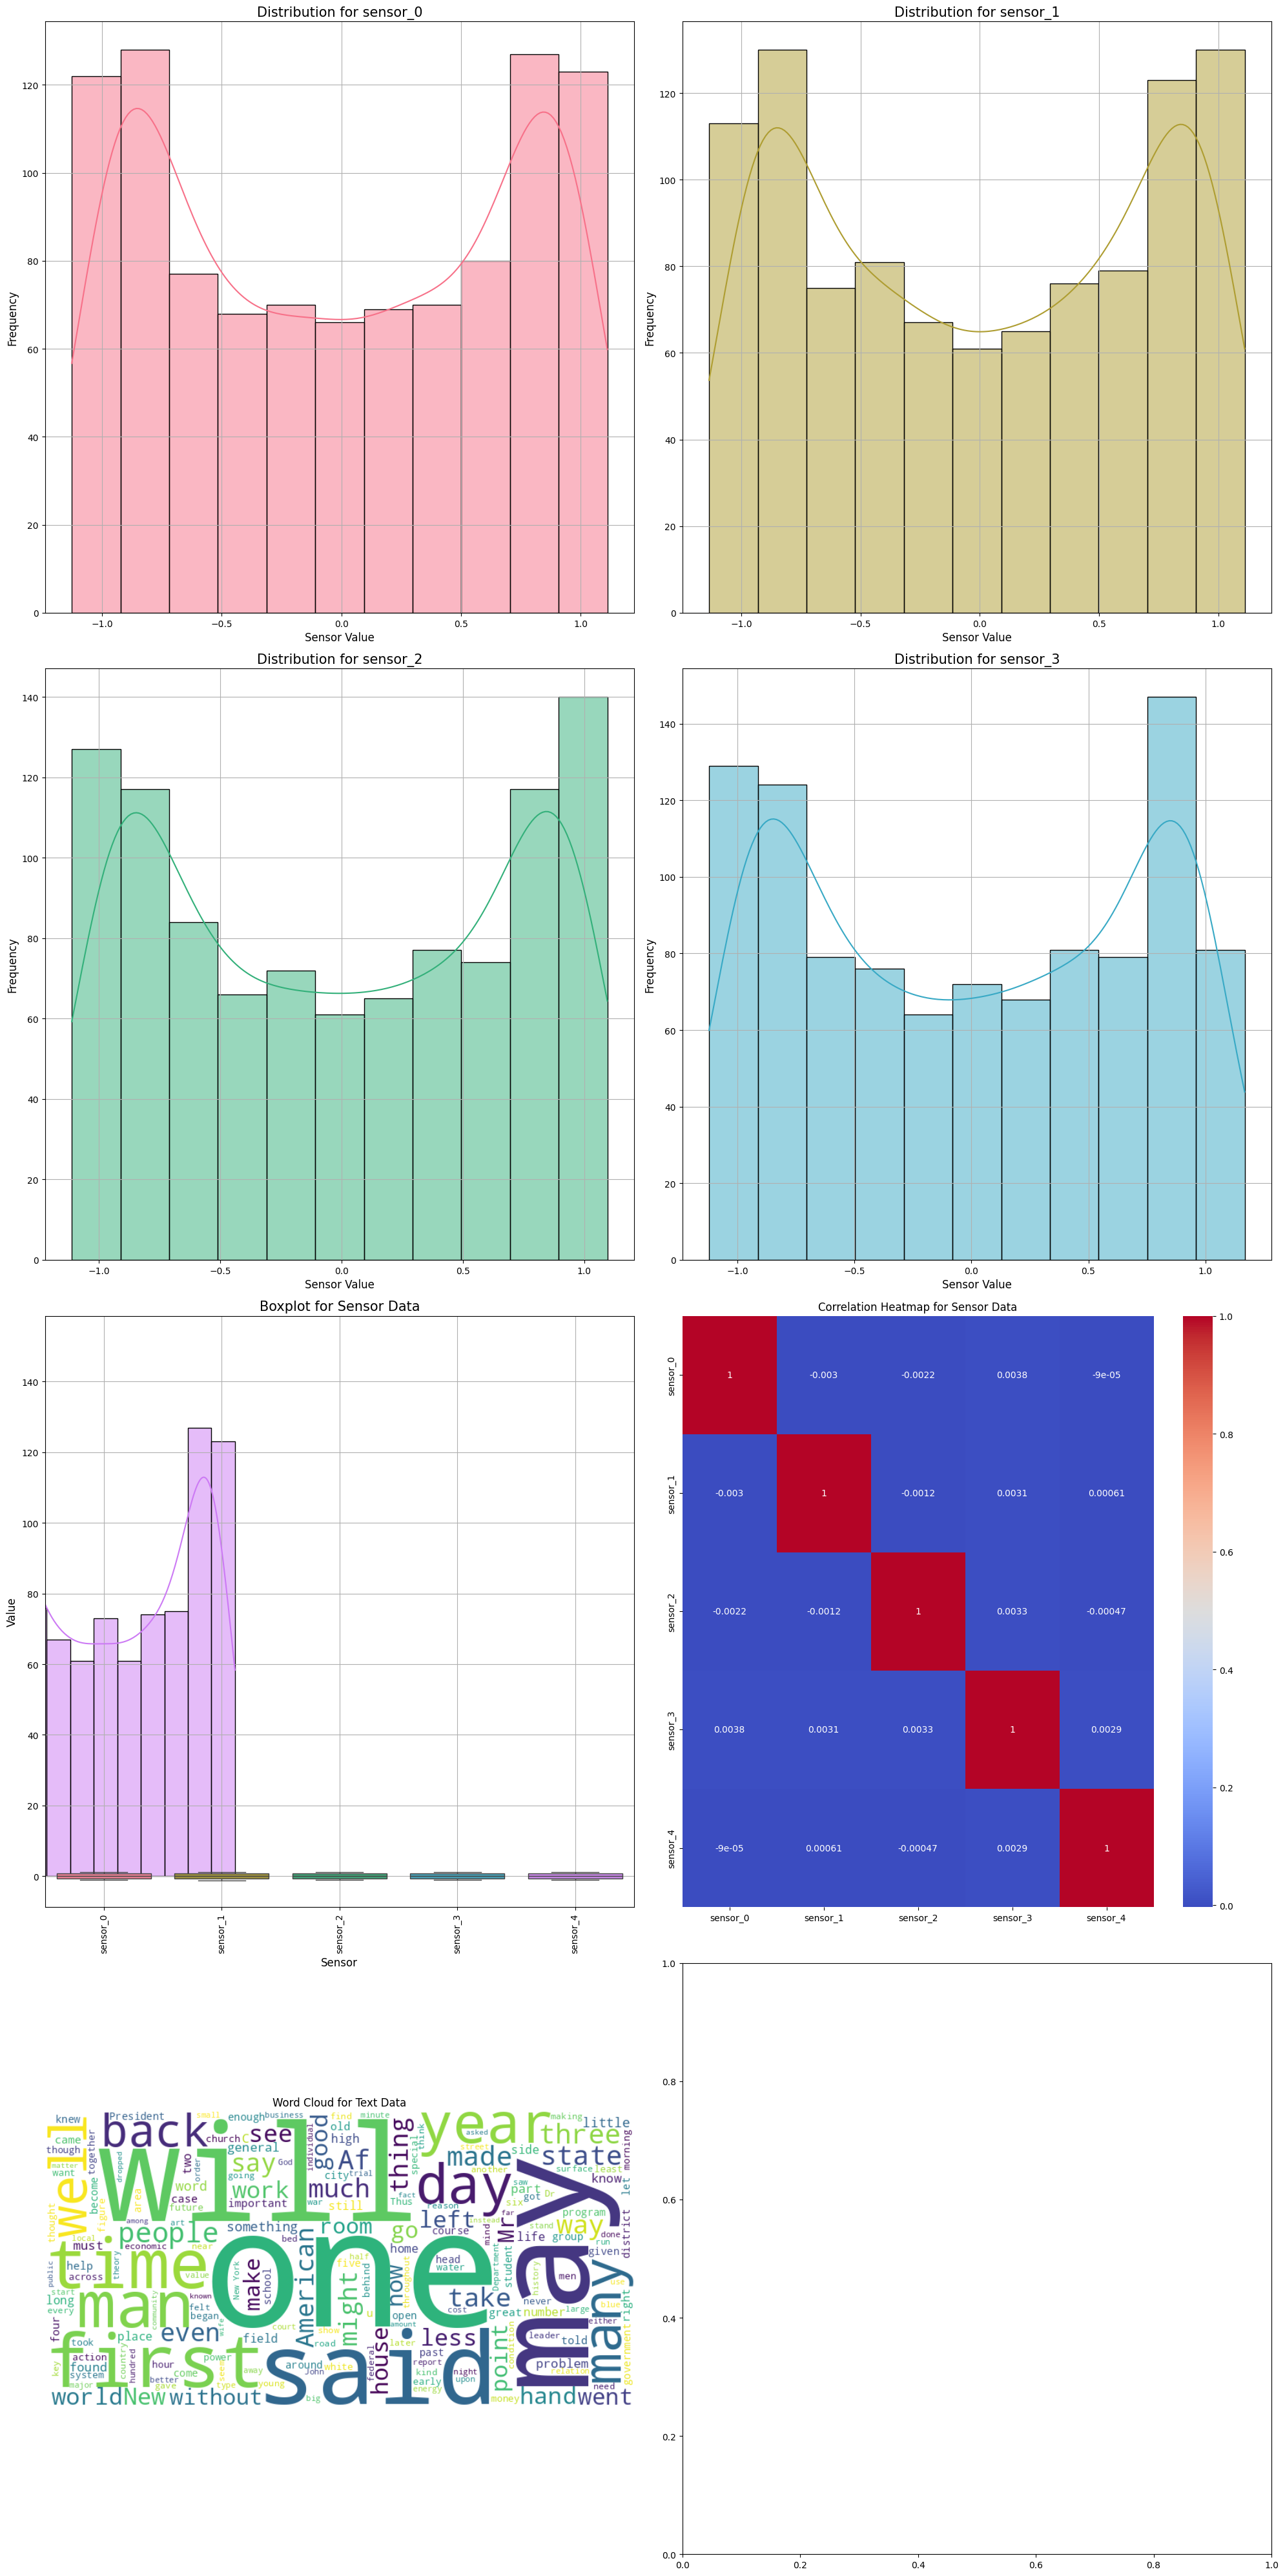

In [25]:
# Load the dataset
data = pd.read_csv('/content/SephsDataV3.csv')

# Visualization for Sensor Data
# Select only the first 5 sensor columns for demonstration
sensor_columns = [col for col in data.columns if 'sensor' in col][:5]
sensor_data = data[sensor_columns]

# Set a consistent color palette
palette = sns.color_palette("husl", len(sensor_columns))

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 40))  # Adjust the size as needed

# Histograms for each sensor
for i, sensor in enumerate(sensor_columns):
    ax = axes[i//2, i%2]  # Determine the position of the subplot
    sns.histplot(sensor_data[sensor], kde=True, color=palette[i], ax=ax)
    ax.set_title(f'Distribution for {sensor}', fontsize=15)
    ax.set_xlabel('Sensor Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True)

# Boxplot for sensor data
sns.boxplot(data=sensor_data, palette=palette, ax=axes[2, 0])
axes[2, 0].set_title('Boxplot for Sensor Data', fontsize=15)
axes[2, 0].tick_params(axis='x', rotation=90)
axes[2, 0].set_xlabel('Sensor', fontsize=12)
axes[2, 0].set_ylabel('Value', fontsize=12)
axes[2, 0].grid(True)

# Correlation Heatmap for sensor data
sns.heatmap(sensor_data.corr(), annot=True, cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Correlation Heatmap for Sensor Data')

# Visualization for NLP Data
text_data = data['text_data'].dropna()  # Drop NaN values if any

# Word Cloud for text data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
axes[3, 0].imshow(wordcloud, interpolation='bilinear')
axes[3, 0].axis('off')
axes[3, 0].set_title('Word Cloud for Text Data')

# Adjust layout
plt.tight_layout()
plt.show()

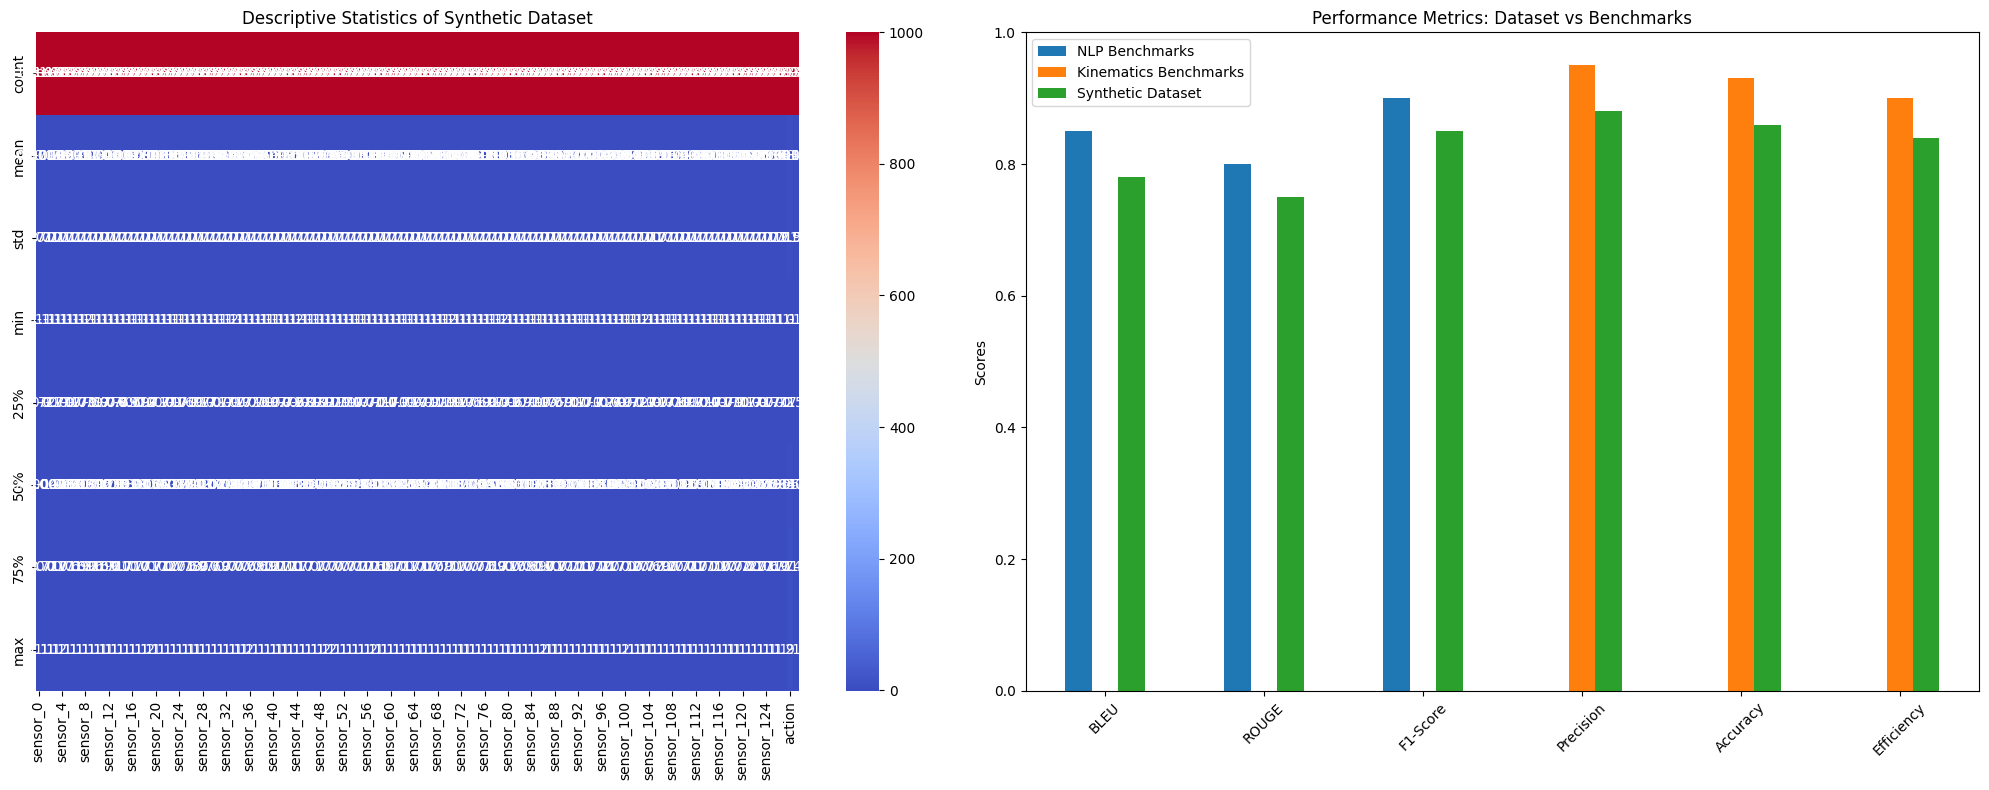

In [26]:
# Placeholder data for benchmarks (Replace with actual values from continuous research)
nlp_benchmarks = {'BLEU': 0.85, 'ROUGE': 0.80, 'F1-Score': 0.90}  # Example NLP benchmarks
kinematics_benchmarks = {'Precision': 0.95, 'Accuracy': 0.93, 'Efficiency': 0.90}  # Example kinematics benchmarks
your_dataset_metrics = {'BLEU': 0.78, 'ROUGE': 0.75, 'F1-Score': 0.85, 'Precision': 0.88, 'Accuracy': 0.86, 'Efficiency': 0.84}

# Convert to DataFrame for visualization
benchmark_df = pd.DataFrame([nlp_benchmarks, kinematics_benchmarks, your_dataset_metrics],
                            index=['NLP Benchmarks', 'Kinematics Benchmarks', 'Synthetic Dataset'])

# Descriptive statistics of the dataset
dataset_stats = df.describe()

# Visualization
plt.figure(figsize=(20, 8))

# Descriptive Statistics Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(dataset_stats, annot=True, cmap='coolwarm')
plt.title('Descriptive Statistics of Synthetic Dataset')

# Benchmark Comparison Bar Chart
plt.subplot(1, 2, 2)
benchmark_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Performance Metrics: Dataset vs Benchmarks')
plt.ylabel('Scores')
plt.ylim(0, 1)  # Normalize score range
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()